# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [220]:
%matplotlib inline
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm
from sklearn.decomposition import PCA
import matplotlib.colors
from sklearn.metrics import silhouette_score


# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

/Users/jshensley/.conda/envs/DataScienceGuidedCapstone/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [221]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [222]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
print(df_transactions.customer_name.value_counts())
df_transactions.head(20)

Sanders    9
Fisher     7
Sanchez    7
Miller     7
Morales    6
          ..
Powell     1
Jones      1
Green      1
Torres     1
Ramirez    1
Name: customer_name, Length: 100, dtype: int64


/Users/jshensley/.conda/envs/DataScienceGuidedCapstone/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1
5,Williams,18,1
6,Williams,22,1
7,Williams,31,1
8,Brown,7,1
9,Brown,29,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns

(Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):

<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [223]:
#your turn

together = pd.merge(df_transactions, df_offers)
print(df_offers.columns)
print('================================================================')
print(together.offer_id.unique())
print('================================================================')
print(len(together.columns)) # offer_id dropped from one
print('================================================================')
print(together[together.offer_id == 0])  # there are no zeros
print('================================================================')
together.head(20)

Index(['offer_id', 'campaign', 'varietal', 'min_qty', 'discount', 'origin',
       'past_peak'],
      dtype='object')
[ 2 24 17 26 18 22 31  7 29 30  8  6 10 14 15 23 12 25 28  1  4  9 11 16
 27  3 19 32  5 20 21 13]
9
Empty DataFrame
Columns: [customer_name, offer_id, n, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []


,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False
2,Martin,2,1,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,January,Pinot Noir,72,17,France,False
5,Mitchell,2,1,January,Pinot Noir,72,17,France,False
6,Peterson,2,1,January,Pinot Noir,72,17,France,False
7,Bell,2,1,January,Pinot Noir,72,17,France,False
8,Cox,2,1,January,Pinot Noir,72,17,France,False
9,Fisher,2,1,January,Pinot Noir,72,17,France,False


In [224]:
together_4eva = together.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
print(together_4eva.sum(axis=1).sort_values(ascending=False))
together_4eva.head(20)

customer_name
Sanders    9
Miller     7
Sanchez    7
Fisher     7
Thomas     6
          ..
Powell     1
Green      1
Ramirez    1
Jones      1
Roberts    1
Length: 100, dtype: int64


offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
Barnes,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
Bell,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bennett,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
Brooks,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
print(together.isnull().sum().sum(), together_4eva.isna().sum().sum())

0 0


There are no missing values anywhere

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings?

    one that minimize the sum of squares
Why?

    they would be the closest

<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [226]:
x_cols = together_4eva.to_numpy()
# and the transpose just in case
x_cols_T = together_4eva.T.to_numpy()

In [227]:
# iterate through various k-values storing the results to get the minimum sum of squares
step = []
inertia = []
centers = {}

for i in range(1,11):
	step.append(i)
	cluster_4eva = KMeans(n_clusters=i,max_iter=500,random_state=1)
	cluster_4eva.fit_predict(x_cols)
	inertia.append(cluster_4eva.inertia_)
	centers[str(i)] = cluster_4eva.cluster_centers_

The values represent points in the plane from a given centre and each point represents a mean distance from it?

In [228]:
# get the minimum value from inertia, get it's index position within inertia in order to get the index position for that k in the step list in order to get a model for that k for further analysis
best_model = step.index(inertia.index(min(inertia)))

# and let's take a look at the best model output
best_model_set = centers[str(step.index(inertia.index(min(inertia))))]
print(best_model_set)

[[ 0.00000000e+00  0.00000000e+00  2.50000000e-01  2.50000000e-01
   0.00000000e+00  5.00000000e-01  1.00000000e+00  5.00000000e-01
   0.00000000e+00  2.50000000e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   2.50000000e-01  7.50000000e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.50000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01  0.00000000e+00]
 [-1.38777878e-17 -1.38777878e-17 -2.77555756e-17 -5.55111512e-17
   0.00000000e+00  6.25000000e-02  2.50000000e-01  1.00000000e+00
  -1.38777878e-17  6.25000000e-02  5.55111512e-17 -6.93889390e-18
   2.50000000e-01 -1.38777878e-17 -2.77555756e-17 -6.93889390e-18
  -2.77555756e-17  3.12500000e-01 -6.93889390e-18 -2.77555756e-17
   0.00000000e+00  0.00000000e+00 -6.93889390e-18 -5.55111512e-17
  -2.77555756e-17  2.77555756e-17  6.25000000e-02 -2.77555756e-17
   3.7500

There are indeed 8 centroids.
Let's create the boxplot with the data from the centers dictionary corresponding to the best model

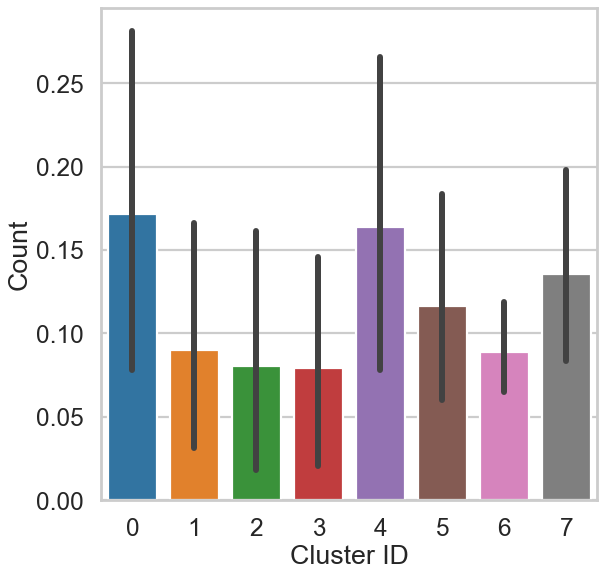

In [229]:
cc = pd.DataFrame(best_model_set)
sns.barplot(data=cc.T)
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.show()

Lots of points around 0 and 4 and some around 5 and 6.

Before reviewing tier 1 code, I found k=8 as being the best k and I will pass into a new model for future use in the next cell.

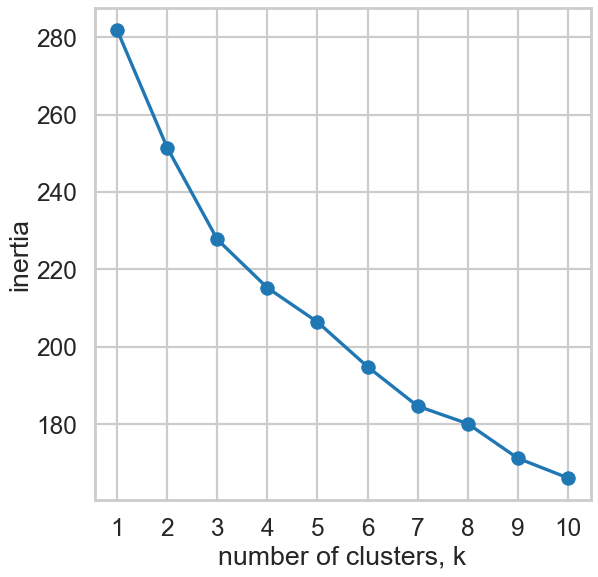

In [230]:
ks = range(1, 11)
inertias_1 = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(x_cols)
    inertias_1.append(model.inertia_)

plt.plot(ks, inertias_1, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

k = 3 or 4???

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

silhouette_avg is: 0.09365573283492713

sample_silhouette_values are: [ 0.25231428 -0.00447998  0.06374686  0.22790341  0.08004897  0.00804086
  0.09323161  0.25478126  0.06763821  0.28068367 -0.00865643  0.07828737
  0.25926399  0.02900704  0.09646988  0.06374686  0.01219547  0.09323161
  0.22255069  0.01254993  0.32714761  0.13308127  0.00688703  0.03069553
  0.03298972  0.06441284 -0.01231515  0.01068787  0.01042621  0.0136865
  0.1712744   0.14424175  0.01068689 -0.02469519  0.11630252  0.2524031
  0.01662024  0.30361381  0.06397528  0.28622288  0.06374686  0.07878072
  0.20613135  0.02012675  0.24070989  0.03355376  0.29101272  0.12531525
  0.03449562  0.00853101 -0.01951632  0.05601254  0.00679949  0.03298972
  0.08668549  0.25478126  0.07878072  0.12605748  0.2057258   0.07220815
 -0.03605053  0.20613135 -0.0339213   0.2057258   0.30225362  0.0524607
  0.03298972 -0.05523931 -0.01563583 -0.02883513 -0.01651096 -0.00865054
 -0.00583467  0.20686873 -0.03062508  0.24095279  0.03481

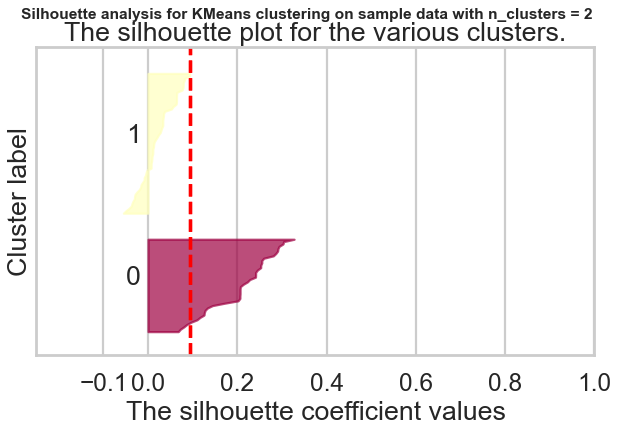

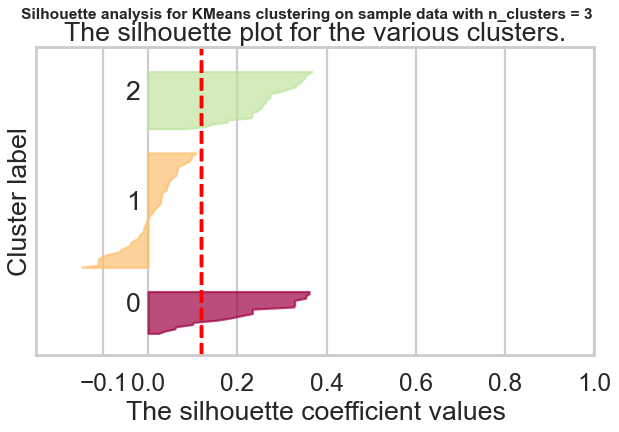

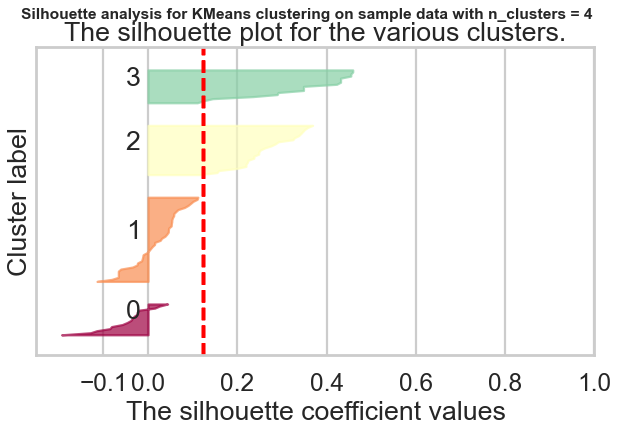

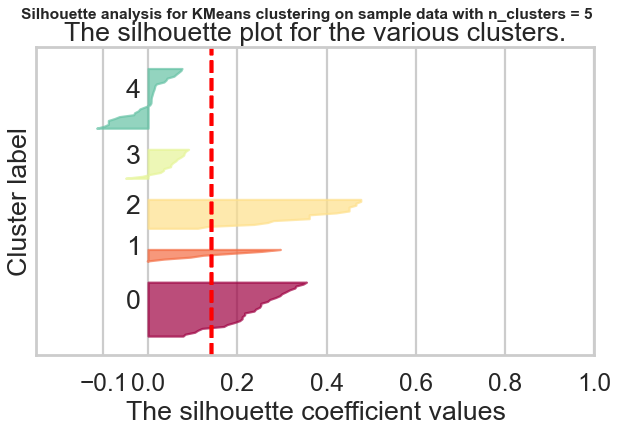

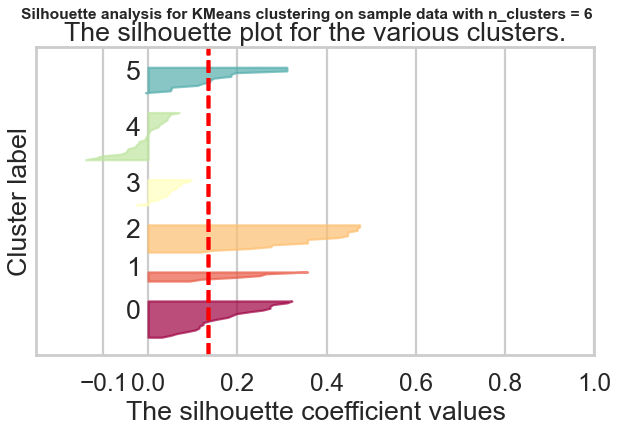

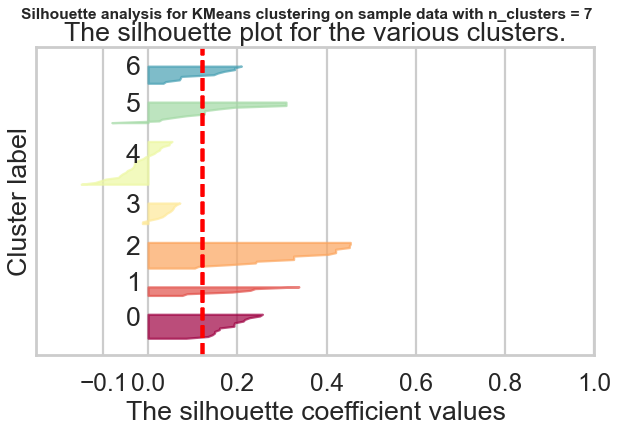

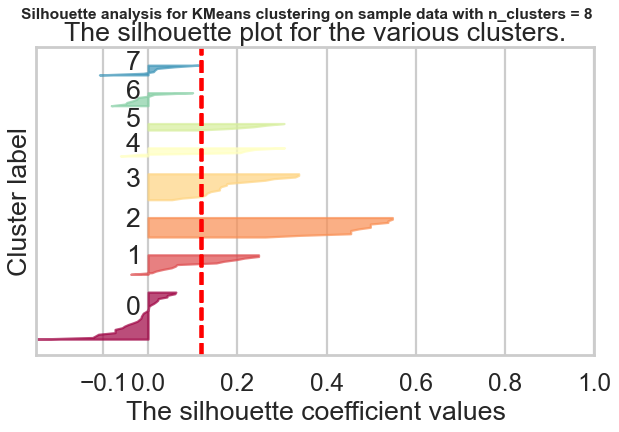

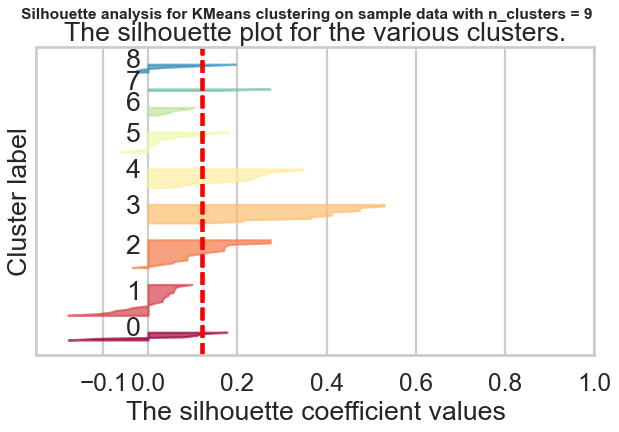

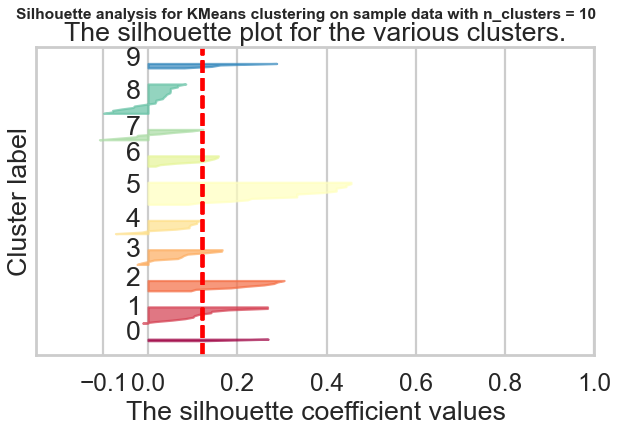

In [231]:
# Your turn.
avg_score = []

# Iterate through Krange with variable K as before
for k in range(2,11):
	fig,ax1 = plt.subplots(1,1)
	fig.set_size_inches(9,5)

	# The 1st subplot is the silhouette plot
	# The silhouette coefficient can range from -1, 1 but in this example all
	# lie within [-0.1, 1]
	# Call set_xlim on ax1
	ax1.set_xlim([-0.25,1])
	# The (n_clusters+1)*10 is for inserting blank space between silhouette
	# plots of individual clusters, to demarcate them clearly.
	ax1.set_ylim([0,len(x_cols) + (k + 1) * 10])

	# Initialize the clusterer with n_clusters value and a random generator
	# seed of 10 for reproducibility.
	sil_cluster = KMeans(n_clusters=k,random_state=10)
	cluster_labels = sil_cluster.fit_predict(x_cols)

	# The silhouette_score gives the average value for all the samples.
	# This gives a perspective into the density and separation of the formed
	# clusters
	# Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
	sil_avg = sklearn.metrics.silhouette_score(x_cols, cluster_labels)
	avg_score.append(sil_avg)
	print(f'silhouette_avg is: {sil_avg}')
	print()
	# Compute the silhouette scores for each sample
	# Call sklearn.metrics.silhouette_samples with the below parameters
	sample_silhouette_values = sklearn.metrics.silhouette_samples(x_cols,cluster_labels)
	print(f'sample_silhouette_values are: {sample_silhouette_values}\n\n\n')

	y_lower = 10
	for i in range(k):
		# Aggregate the silhouette scores for samples belonging to
		# cluster i, and sort them
		# Make a variable called ith_cluster_silhouette_values
		ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

		# Call sort() on this variable
		ith_cluster_silhouette_values.sort()

		# Call shape[0] on ith_cluster_silhouette_values
		size_cluster_i = ith_cluster_silhouette_values.shape[0]
		y_upper = y_lower + size_cluster_i

		cmap = cm.get_cmap("Spectral")
		color = cmap(float(i) / k)
		ax1.fill_betweenx(np.arange(y_lower,y_upper),
		                  0,ith_cluster_silhouette_values,
		                  facecolor=color,edgecolor=color,alpha=0.7)

		# Label the silhouette plots with their cluster numbers at the middle
		# This requires calling text() on ax1
		ax1.text(-0.05,y_lower + 0.5 * size_cluster_i,str(i))

		# Compute the new y_lower for next plot
		y_lower = y_upper + 10  # 10 for the 0 samples

		# Setting title, xlabel and ylabel
		# noinspection PyUnboundLocalVariable
		ax1.set_title("The silhouette plot for the various clusters.")
		ax1.set_xlabel("The silhouette coefficient values")
		ax1.set_ylabel("Cluster label")

		# The vertical line for average silhouette score of all the values
		# This requires axvline()
		ax1.axvline(x=sil_avg,color="red",linestyle="--")

		ax1.set_yticks([])  # Clear the yaxis labels / ticks
		ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])

		plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
					  "with n_clusters = %d" % k),
					 fontsize=14,fontweight='bold')

Sticking with 8 or 9 due the most silhouettes in the positive and extending out the furthest.

Text(0, 0.5, 'Average Silhouette Score')

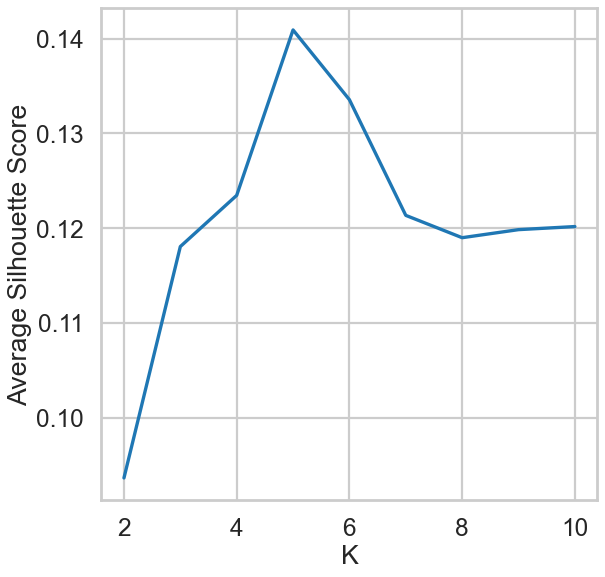

In [232]:
kr = list(range(2, 11))
plt.plot(kr, avg_score)
plt.xlabel("K")
plt.ylabel("Average Silhouette Score")

That there is no silver bullet for choosing k as I'm getting competing values. The documentation and reading up does say that this is likely to be the case. My conclusion is I might try a few different model types or let stakeholders know that decisions should be made with caution since this model didn't provide sufficient data.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

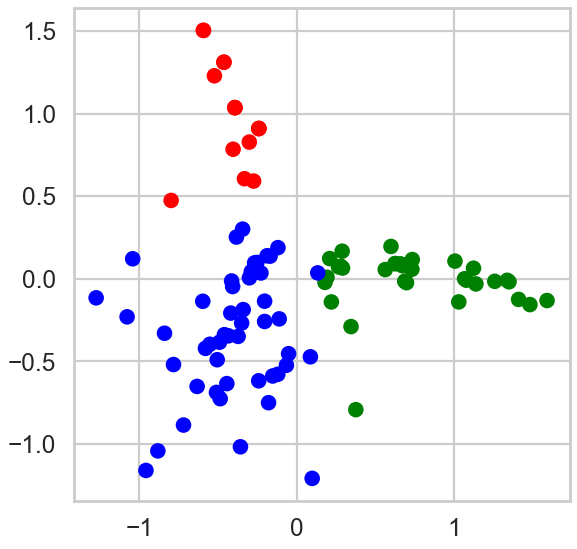

In [233]:
#your turn
# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans
pca_model = KMeans(n_clusters=3)

# Call a fit_predict() on X
clusters = pca_model.fit_predict(x_cols)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pca = PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(x_cols))  # the asterisk indicates the presence of a matrix
plt.scatter(pc1, pc2, c=clusters.tolist(), cmap=cmap)

[1 0 2 1 0 0 2 1 0 1 0 2 1 0 0 2 0 2 1 0 1 1 0 0 2 0 0 0 0 2 1 1 0 0 1 1 0
 1 0 1 2 2 1 0 1 0 1 1 0 0 0 0 0 2 0 1 2 1 1 0 0 1 0 1 1 2 2 0 0 0 0 0 0 1
 0 1 2 1 1 2 0 0 0 2 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0]

offer_id
1     10
2     10
3      6
4     12
5      4
6     12
7     19
8     20
9     10
10     7
11    13
12     5
13     6
14     9
15     6
16     5
17     7
18    14
19     5
20     6
21     4
22    21
23     5
24    12
25     6
26    15
27     9
28     6
29    17
30    22
31    17
32     4
dtype: int64

offer_id       1   2   3   4   5   6   7   8   9   10  ...  23  24  25  26  \
customer_name                                          ...                   
Allen           0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   
Baker           0   0   0   0   0   0   1   0   0   1  ...   0   0   0   0   
Barnes          0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   
Brooks          0   0   1   0   0   0   0   1   0   0  ...   0   0   0   0   
Butler          

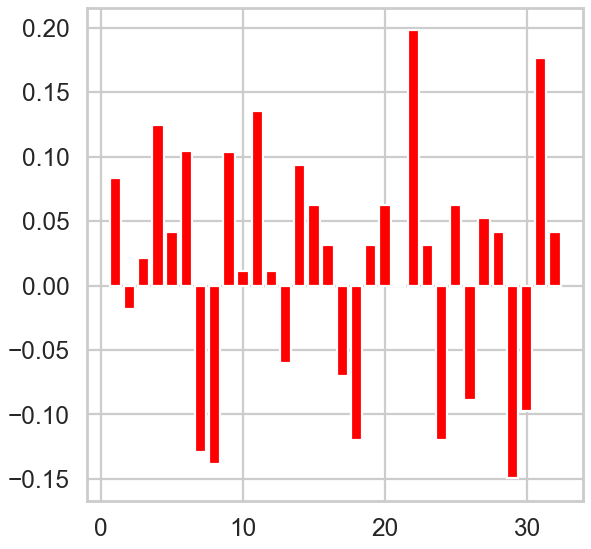

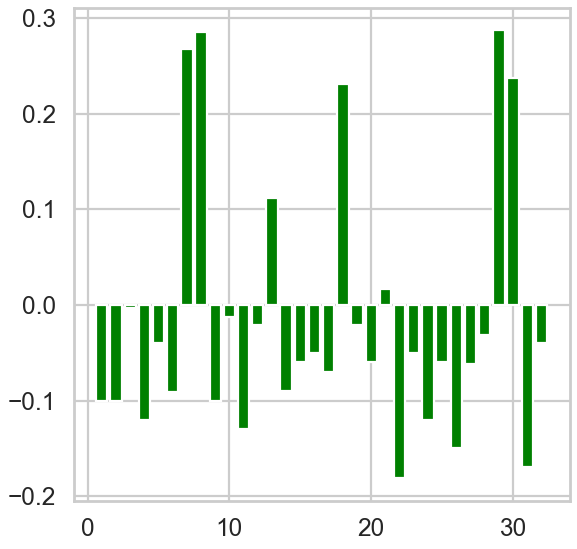

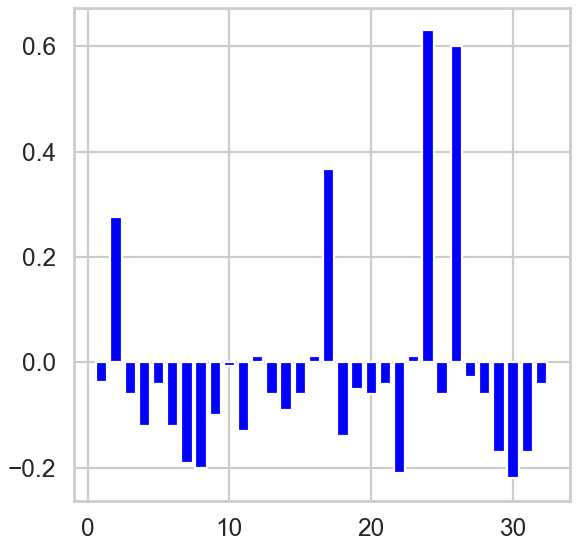

In [234]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
model = KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(x_cols)

print(cluster_assignments)
print()
print(together_4eva.sum(axis=0))

colors = ['red','green','blue']

offer_proportions = together_4eva.sum(axis=0) / 100  # There are 100 customers

for i in range(3):
	plt.figure(i)
	cluster = together_4eva[cluster_assignments == i]
	print()
	print(cluster)
	offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
	lift = offer_proportions_cluster - offer_proportions
	plt.bar(range(1,33),lift,color=colors[i])

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

0.14386392674547932 0.1080028932422651
2


Text(0, 0.5, 'Explained Variance')

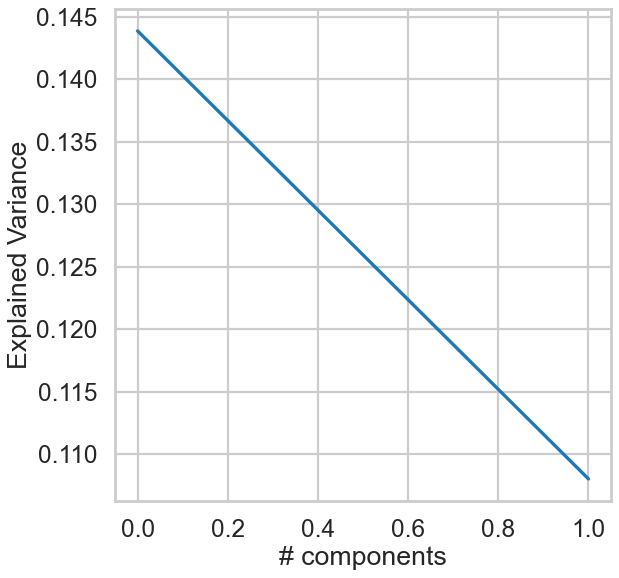

In [235]:
#your turn
another_pca = PCA(n_components=2)

# Call fit() on pca, with X passed to the method
another_pca.fit(x_cols)

# Let's finish this :)  Make a variable called variance
pc1, pc2 = pca.explained_variance_ratio_
print(pc1, pc2)
print(len(vars))

# Plot() it
plt.plot(range(len(pca.explained_variance_ratio_)), vars)

# Label the axes
plt.xlabel("# components")
plt.ylabel("Explained Variance")

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call.

In [236]:
len(df_offers.offer_id)

32

In [237]:
df_transactions

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1
...,...,...,...
319,Fisher,11,1
320,Fisher,22,1
321,Fisher,28,1
322,Fisher,30,1


In [238]:
# lets see which offers were chosen most. They are 30, 22, 9, 7
top_8_offers = together_4eva.sum(axis=0).sort_values(ascending=False).index.to_list()[:4]
top_8_offers

[30, 22, 8, 7]

In [239]:
# let's see who got the most offers
together_4eva.sum(axis=1).sort_values(ascending=False)

customer_name
Sanders    9
Miller     7
Sanchez    7
Fisher     7
Thomas     6
          ..
Powell     1
Green      1
Ramirez    1
Jones      1
Roberts    1
Length: 100, dtype: int64

In [240]:
# let's look at Sander's chosen offers
sanders_chose = together_4eva.T
sanders_chose[sanders_chose['Sanders']==1].index.to_list()

[1, 4, 5, 6, 9, 11, 20, 25, 26]


Goal:
We’re trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

Summary:
If there are 32 offer IDs, and 8 clusters then I'm thinking there are 4 offer IDs that are most likely to be chosen based on the people:::

32 / 8 = 4

Sanders chose the most offers: [1, 4, 5, 6, 9, 11, 20, 25, 26]

The top 4 chosen were: [30, 22, 8, 7]

So the top buyer, Sanders, didn't choose any of the top 4 offers????

Does the data say that Sanders is an outlier?

Then could we say that people NOT like Sanders are more likely to buy the best 4 offers and people like Sanders are likely to by what he did?

I believe the the data isn't suited for the model.
Or there isn't sufficient data to model properly. There were a lot of zeros in there.


### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


Affinity propagation:

In [241]:
not_together_anymore_clusters = {}

# I'll transpose the matrix to get offer_id values out
for i in np.linspace(0.5, 1.0, 6):
	not_together_anymore = AffinityPropagation(damping=0.5)
	not_together_anymore.fit_predict(x_cols.T)
	not_together_anymore_clusters[str(i)] = set(not_together_anymore.cluster_centers_indices_)

whats_in_common_together = [n for n in not_together_anymore_clusters.values()]

whats_in_the_family = whats_in_common_together[0] & \
							 whats_in_common_together[1] & \
							 whats_in_common_together[2] & \
							 whats_in_common_together[3] & \
							 whats_in_common_together[4] & \
							 whats_in_common_together[5]

for k, v in not_together_anymore_clusters.items():
	print(f'damping: {k}\ncluster indices: {v}\nwith length: {len(v)}\n\n')

damping: 0.5
cluster indices: {6, 7, 19, 20, 21, 22, 23, 28, 29, 30}
with length: 10


damping: 0.6
cluster indices: {6, 7, 19, 20, 21, 22, 23, 28, 29, 30}
with length: 10


damping: 0.7
cluster indices: {6, 7, 19, 20, 21, 22, 23, 28, 29, 30}
with length: 10


damping: 0.8
cluster indices: {6, 7, 19, 20, 21, 22, 23, 28, 29, 30}
with length: 10


damping: 0.9
cluster indices: {6, 7, 19, 20, 21, 22, 23, 28, 29, 30}
with length: 10


damping: 1.0
cluster indices: {6, 7, 19, 20, 21, 22, 23, 28, 29, 30}
with length: 10




not much variety here with all damping values presenting 10 clusters.

In [242]:
print(f'All 6 models have indices {whats_in_the_family} in common, which is equal to all of the models so these offers are the best')

All 6 models have indices {6, 7, 19, 20, 21, 22, 23, 28, 29, 30} in common, which is equal to all of the models so these offers are the best


Spectral clustering

Reading the documentation, this sentence jumped out:

'In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex...'

Non-convex?

Isn't that just 'concave?'

Gonna reduce the dimensions to the two most important for graphing

In [243]:
together_4eva.T.head()

customer_name,Adams,Allen,Anderson,Bailey,Baker,Barnes,Bell,Bennett,Brooks,Brown,...,Turner,Walker,Ward,Watson,White,Williams,Wilson,Wood,Wright,Young
offer_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
is_it_concave_or_convex = another_pca.fit_transform(x_cols)
its_pandacave = pd.DataFrame(is_it_concave_or_convex)
its_pandacave.columns = ['is_convex', 'is_concave']

pca_transform = another_pca.fit_transform(x_cols.T)
is_it_concave_or_convex_T = another_pca.fit_transform(x_cols)
its_pandacave_T = pd.DataFrame(is_it_concave_or_convex)
its_pandacave_T.columns = ['is_convex_T', 'is_concave_T']

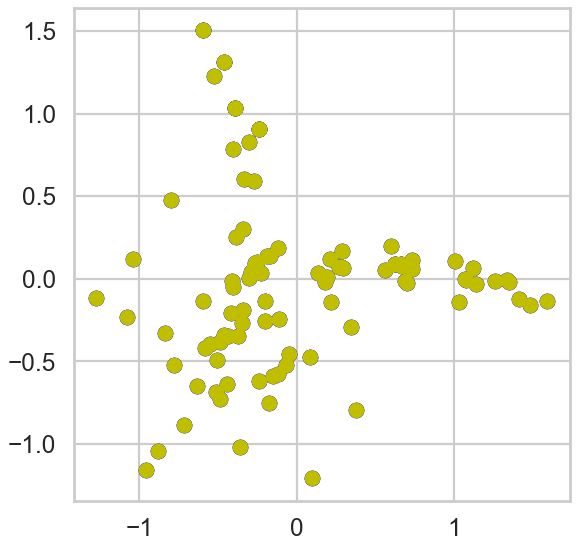

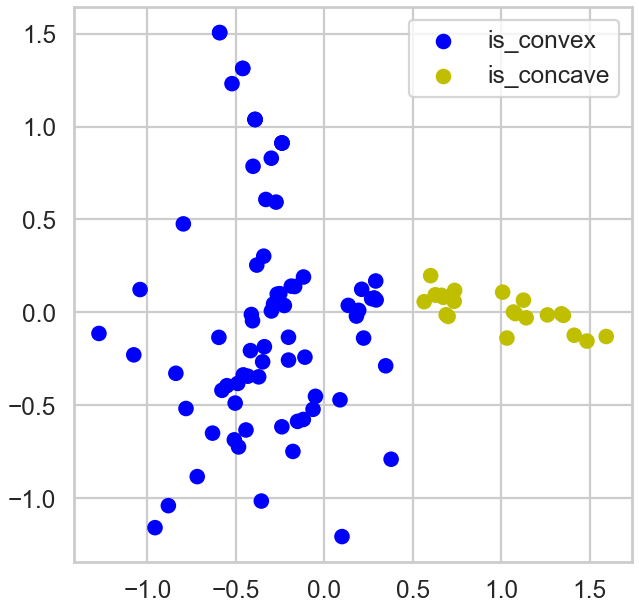

In [245]:
# some code from https://www.geeksforgeeks.org/ml-spectral-clustering/

# Building the clustering model
spectral_model_rbf = SpectralClustering(n_clusters = 2, affinity ='rbf')

# Training the model and Storing the predicted cluster labels
labels_rbf = spectral_model_rbf.fit_predict(its_pandacave)
labels_rbf_T = spectral_model_rbf.fit_predict(its_pandacave_T)

# Building the label to colour mapping
colours = {}
colours[0] = 'b'
colours[1] = 'y'

# Building the colour vector for each data point
cvec = [colours[label] for label in labels_rbf]

# Plotting the clustered scatter plot
b = plt.scatter(its_pandacave['is_convex'], its_pandacave['is_concave'], color ='b')
y = plt.scatter(its_pandacave['is_convex'], its_pandacave['is_concave'], color ='y')

# Plotting it with the transpose to see if there are any differences
bT = plt.scatter(its_pandacave_T['is_convex_T'], its_pandacave_T['is_concave_T'], color ='b')
yT = plt.scatter(its_pandacave_T['is_convex_T'], its_pandacave_T['is_concave_T'], color ='y')

plt.figure(figsize =(9, 9))
plt.scatter(its_pandacave['is_convex'],its_pandacave['is_concave'], c = cvec)
plt.legend((b, y), ('is_convex', 'is_concave'))
plt.show()


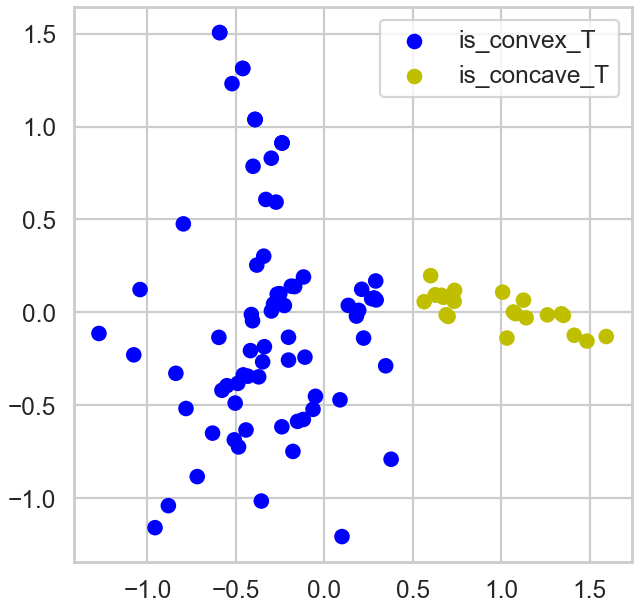

In [246]:
# The transpose
plt.figure(figsize =(9, 9))
plt.scatter(its_pandacave_T['is_convex_T'],its_pandacave_T['is_concave_T'], c = cvec)
plt.legend((bT, yT), ('is_convex_T', 'is_concave_T'))
plt.show()

Is concave represents the PCA's first column. And the there was no change with the transpose.

/Users/jshensley/.conda/envs/DataScienceGuidedCapstone/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


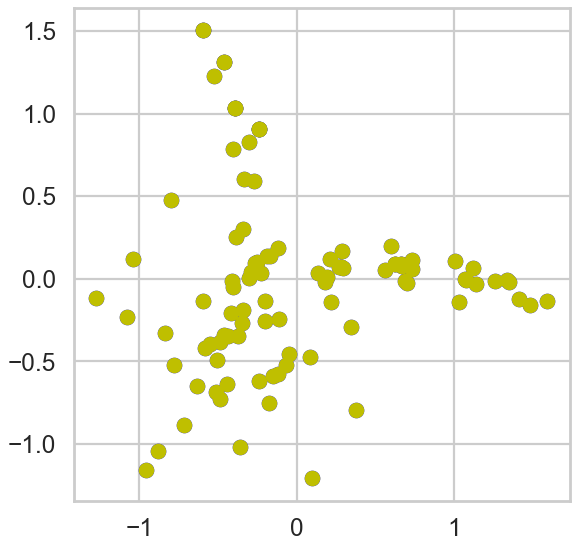

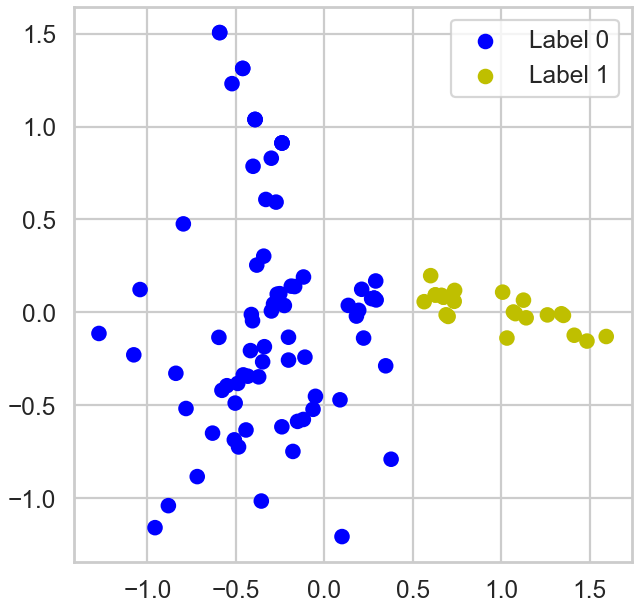

In [247]:
spectral_model_nn = SpectralClustering(n_clusters = 2, affinity ='nearest_neighbors')

labels_nn = spectral_model_nn.fit_predict(its_pandacave)

# Building the label to colour mapping
colours = {}
colours[0] = 'b'
colours[1] = 'y'

# Building the colour vector for each data point
cvec = [colours[label] for label in labels_rbf]

# Plotting the clustered scatter plot

b = plt.scatter(its_pandacave['is_convex'], its_pandacave['is_concave'], color ='b');
y = plt.scatter(its_pandacave['is_convex'], its_pandacave['is_concave'], color ='y');

plt.figure(figsize =(9, 9))
plt.scatter(its_pandacave['is_convex'],its_pandacave['is_concave'], c = cvec)
plt.legend((b, y), ('Label 0', 'Label 1'))
plt.show()


[0.4159762672079344, 0.4159762672079344]


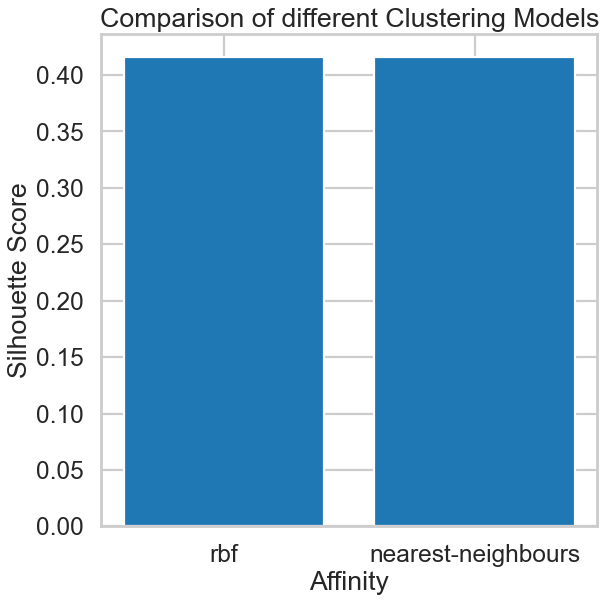

In [248]:
# List of different values of affinity
affinity = ['rbf', 'nearest-neighbours']

# List of Silhouette Scores
s_scores = []

# Evaluating the performance
s_scores.append(silhouette_score(its_pandacave, labels_rbf))
s_scores.append(silhouette_score(its_pandacave, labels_nn))

print(s_scores)
# Plotting a Bar Graph to compare the models
plt.bar(affinity, s_scores)
plt.xlabel('Affinity')
plt.ylabel('Silhouette Score')
plt.title('Comparison of different Clustering Models')
plt.show()


This method shed noo new light on anything and if anything reinforced my earlier conclusions. Medium n_samples and small n_clusters is what this model is best for, and i think we are dealing with small n_samples and higher clusters.

Agglomerative clustering and DBSCAN are for large n_samples and larger n_clusters and this dataset has neither so the effort then is for demonstration purposes since there will be no useful information coming from this,  and since I've demonstrated the other 2 above and I've spent significant time on this project, I hope it's understandable I move on.